In [207]:
import pandas as pd
from os.path import join, exists
import os
from scipy import stats
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [208]:
# columnArr = ["activityID",
#               "handT", "handAx_16", "handAy_16", "handAz_16",
#               "handAx_6", "handAy_6", "handAz_6",
#               "handGx", "handGy", "handGz",
#               "handMx", "handMy", "handMz",
#               "chestT", "chestAx_16", "chestAy_16", "chestAz_16",
#               "chestAx_6", "chestAy_6", "chestAz_6",
#               "chestGx", "chestGy", "chestGz",
#               "chestMx", "chestMy", "chestMz",
#               "ankleT", "ankleAx_16", "ankleAy_16", "ankleAz_16",
#               "ankleAx_6", "ankleAy_6", "ankleAz_6",
#               "ankleGx", "ankleGy", "ankleGz",
#               "ankleMx", "ankleMy", "ankleMz"]
columnArr = [ "AccX", "AccY", "AccZ","GyroX", "GyroY","GyroZ","Class"]

In [209]:
#calculating the MAV
def calculateMAV(dataF):
    absoluteDataFrame = dataF.abs()
    MAVFrame = absoluteDataFrame.mean()
    return MAVFrame

# calculating harmonic mean
def calculateHarmonicMean(dataF):
    dataF.fillna(1)
    hMeanFrame = pd.DataFrame(stats.hmean(dataF.abs(), axis=0))
    return hMeanFrame

# calculating RMS
def calculateRMS(dataF):
    squaredFrame = dataF ** 2
    meanFrame = squaredFrame.mean()
    RMSFrame = meanFrame.apply(np.sqrt)
    return RMSFrame

#calculating variance
def calculateVariance(dataF):
    varFrame = dataF.var()
    return varFrame

# calculating cummulative length
def calculateCumLength(dataF):
    diffFrame = dataF.diff()
    cumLengthFrame = diffFrame.sum()
    return cumLengthFrame

# calcualting skew
def calculateSkew(dataF):
    skewFrame = dataF.skew()
    return skewFrame

# calculating energy
def calculateEnergy(dataF):
    squaredFrame = dataF ** 2
    energyFrame = squaredFrame.sum()
    return energyFrame

In [210]:
def readDataFromFile(filePath, windowSize):

    print('Reading data from file ' + filePath)
    data =  pd.read_excel(filePath)

    print(data.shape)
    print(data.dtypes)
    print("Removing unused columns from the data")

    # removing orientation columns from the data
    data = data.drop(data.columns[[0, 1]], axis=1)
    print(data.shape)
    # creating of copy of the entire dataFrame
    df = data.copy()
    df.columns = columnArr
    
    (dataRows, dataCols) = df.shape

    # replacing the Nan values
    df.fillna(method='ffill')
    df.fillna(0)

    # extracting features from each column
    # MAV - Mean Absolute Value
    # Harmonic mean
    # RMS
    # Variance
    # Cumulative length
    # Skewness
    # Energy of the signal


    destDf = pd.DataFrame()  # destination data frame
    startIndex = 0
    endIndex = startIndex + windowSize
    shouldLoopContinue = True
    while (shouldLoopContinue):
        window = df.iloc[startIndex:endIndex, :]

        # dividing data based on the label
        labelList = window['Class'].unique().tolist()
        #print(labelList)

        for label in labelList:
                window_div = window[window["Class"] == label]
                sensorFrame = window_div.iloc[:, 0:6]

                rowFrame = pd.DataFrame([window_div.iloc[0, 6]])
                MAVFrame = calculateMAV(sensorFrame)
                # HMeanFrame = calculateHarmonicMean(sensorFrame)
                RMSFrame = calculateRMS(sensorFrame)
                varFrame = calculateVariance(sensorFrame)
                cumLengthFrame = calculateCumLength(sensorFrame)
                skewFrame = calculateSkew(sensorFrame)
                energyFrame = calculateEnergy(sensorFrame)
                rowFrame = pd.concat([rowFrame, MAVFrame, RMSFrame, varFrame, cumLengthFrame, skewFrame, energyFrame], ignore_index=True)
                destDf = destDf.append(rowFrame.transpose(), ignore_index=True)
               

        startIndex = endIndex
        endIndex = startIndex + windowSize

        if (startIndex < dataRows and endIndex < dataRows):
            shouldLoopContinue = True
        elif (startIndex < dataRows and endIndex > dataRows):
            endIndex = dataRows
            shouldLoopContinue = True
        else:
            shouldLoopContinue = False
    print(destDf.shape)
    print(destDf)
    return destDf

In [211]:
def dumpFeaturesToFile(fileArr, sourceDir, dataPath, labelPath,win_size):

    combinedDf = pd.DataFrame()
    for fileName in fileArr:
        filePath = join(sourceDir, fileName)
        retreivedDf = readDataFromFile(filePath,win_size)
        if ((retreivedDf.shape)[0] > 0):
            combinedDf = combinedDf.append(retreivedDf, ignore_index=True)
            print(combinedDf.shape)

    combinedDf.iloc[:, 1:37].to_csv(dataPath, index=False)
    combinedDf.iloc[:,0].to_csv(labelPath, index=False)


In [214]:
sourceDir = "C:/Users/dhruv/OneDrive/Desktop/698/Project/raw_data/"  # path for total_raw_data

destinationDir = "C:/Users/dhruv/OneDrive/Desktop/698/Project/"
win_size = 30  #window_size 
preprocessedDirName = "PreProccessed_Data_Window_Sizewise/W"+str(win_size)
preprocessedDirPath = join(destinationDir, preprocessedDirName)
train_data = "Train_Data.csv"
train_label = "Train_Label.csv"
# validation_data = "Validation_Data.csv"
# validation_label = "Validation_Label.csv"
# test_data = "Test_Data.csv"
# test_label = "Test_Label.csv"

    #creating destination directories if not present
if not exists(preprocessedDirPath):
        os.makedirs(preprocessedDirPath)

trainingFiles = ["Final_Badminton_Dataset.xlsx"]    # file_name for total_data
    #validationFiles = ["subject108.dat"]
    #testingFiles = ["subject109.dat"]

    # Generating the features for the training data
dumpFeaturesToFile(trainingFiles, sourceDir, join(preprocessedDirPath, train_data), join(preprocessedDirPath, train_label),win_size)

    # Generating the features for the validation data
    #dumpFeaturesToFile(validationFiles, sourceDir, join(preprocessedDirPath, validation_data), join(preprocessedDirPath, validation_label), False, True)

    # Generating the features for the test data
    #dumpFeaturesToFile(testingFiles, sourceDir, join(preprocessedDirPath, test_data), join(preprocessedDirPath, test_label), False, True)


Reading data from file C:/Users/dhruv/OneDrive/Desktop/698/Project/raw_data/Final_Badminton_Dataset.xlsx
(16215, 9)
Timestamp             int64
DateTime     datetime64[ns]
AccX                float64
AccY                float64
AccZ                float64
GyroX               float64
GyroY               float64
GyroZ               float64
Class                object
dtype: object
Removing unused columns from the data
(16215, 7)
(544, 37)
        0         1         2         3        4        5        6         7   \
0    Serve   1.05293  0.410588  0.221989  107.963  51.8435  65.5579   1.20971   
1    Serve   1.12917  0.548218  0.340674  106.652    54.31   81.499   1.45682   
2    Serve  0.958781  0.283618  0.175195  65.5467  22.3852  34.9634  0.981223   
3    Serve    1.3437  0.531014  0.497892  147.285  112.638  115.835   1.74104   
4    Serve   1.29029  0.617806  0.587459  169.221  116.359  117.066    1.6806   
5    Serve   1.34745  0.682918  0.658325  147.236  111.939  89.6006   1.7

In [216]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W30/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W30/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)


# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)

print("---------------Training RandomForest Classifier Model-----------")
clf =  RandomForestClassifier(random_state=1)
clf.fit(X_train,y_train)

print("--------------------Testing the Model------------------")
label_predicted = clf.predict(X_test)

accuracy =  accuracy_score(y_test, label_predicted)

print("Test Accuracy")
print(accuracy * 100)


Total Data 
(544, 36)
Total Data label 
(544,)
Dividing the data to train and test 
Dimensions of train data 
(435, 36)
Dimensions of training labels 
(435,)
Dimensions of test data 
(109, 36)
Dimensions of test labels 
(109,)
---------------Training RandomForest Classifier Model-----------
--------------------Testing the Model------------------
Test Accuracy
91.74311926605505


In [220]:
from sklearn import metrics
print (metrics.classification_report(y_test, label_predicted))

             precision    recall  f1-score   support

   Backhand       0.93      0.82      0.87        17
      Clear       0.95      1.00      0.97        19
      Serve       0.95      0.90      0.92        20
      Smash       0.93      0.96      0.94        53

avg / total       0.94      0.94      0.93       109



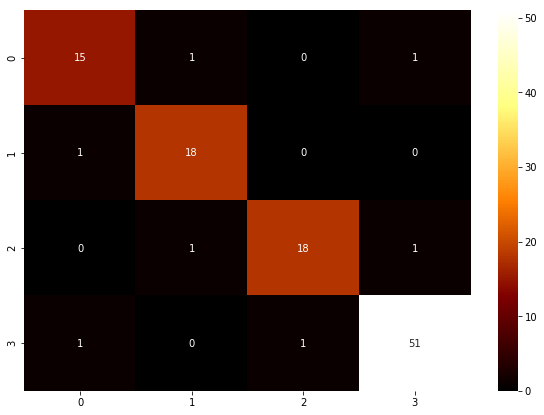

In [240]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, label_predicted)
import seaborn as sn
df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="afmhot")

In [235]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neural_network import MLPClassifier

# getting the data
print("----------------------------------- Implementing MLP Classifier Model-------------------------------------------------------")
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W30/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W30/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)


# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)

print("---------------Training MLP Classifier Model-----------")
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100),verbose=True, max_iter=100, tol=1e-6)
clf.fit(X_train,y_train)

print("--------------------Testing the Model------------------")
label_predicted = clf.predict(X_test)

accuracy =  accuracy_score(y_test, label_predicted)

print("Test Accuracy")
print(accuracy * 100)

----------------------------------- Implementing MLP Classifier Model-------------------------------------------------------
Total Data 
(544, 36)
Total Data label 
(544,)
Dividing the data to train and test 
Dimensions of train data 
(435, 36)
Dimensions of training labels 
(435,)
Dimensions of test data 
(109, 36)
Dimensions of test labels 
(109,)
---------------Training MLP Classifier Model-----------
Iteration 1, loss = 1.37018654
Iteration 2, loss = 1.33426305
Iteration 3, loss = 1.31311652
Iteration 4, loss = 1.30305060
Iteration 5, loss = 1.30318148
Iteration 6, loss = 1.30467066
Iteration 7, loss = 1.30146987
Iteration 8, loss = 1.29326828
Iteration 9, loss = 1.28390926
Iteration 10, loss = 1.27586965
Iteration 11, loss = 1.26706694
Iteration 12, loss = 1.25881174
Iteration 13, loss = 1.25017134
Iteration 14, loss = 1.23915568
Iteration 15, loss = 1.22570691
Iteration 16, loss = 1.21003710
Iteration 17, loss = 1.19072250
Iteration 18, loss = 1.17161788
Iteration 19, loss = 1.15

In [236]:
from sklearn import metrics
print (metrics.classification_report(y_test, label_predicted))

             precision    recall  f1-score   support

   Backhand       0.88      0.88      0.88        17
      Clear       0.90      0.95      0.92        19
      Serve       0.95      0.90      0.92        20
      Smash       0.96      0.96      0.96        53

avg / total       0.94      0.94      0.94       109



In [183]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from sklearn import svm

# getting the data
print("----------------------------------- Implementing SVM -------------------------------------------------------")
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)



# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)

print(" --------------Training SVC (One vs Rest)in svm ------------------------")
classifier = svm.SVC(decision_function_shape="ovr", kernel= "poly", random_state=1)
classifier.fit(X_train, y_train)

print("------------------------ Testing the model-----------------------------")
label_predicted = classifier.predict(X_test)

accuracy = accuracy_score(y_test, label_predicted)

print("Test Accuracy ")
print(accuracy * 100)


----------------------------------- Implementing SVM -------------------------------------------------------
Total Data 
(328, 36)
Total Data label 
(328,)
Dividing the data to train and test 
Dimensions of train data 
(262, 36)
Dimensions of training labels 
(262,)
Dimensions of test data 
(66, 36)
Dimensions of test labels 
(66,)
 --------------Training SVC (One vs Rest)in svm ------------------------
------------------------ Testing the model-----------------------------
Test Accuracy 
43.93939393939394


In [184]:
from sklearn import metrics
print (metrics.classification_report(y_test, label_predicted))

             precision    recall  f1-score   support

   Backhand       0.00      0.00      0.00        13
      Clear       0.00      0.00      0.00        15
      Serve       0.00      0.00      0.00         9
      Smash       0.44      1.00      0.61        29

avg / total       0.19      0.44      0.27        66



C:\Users\dhruv\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


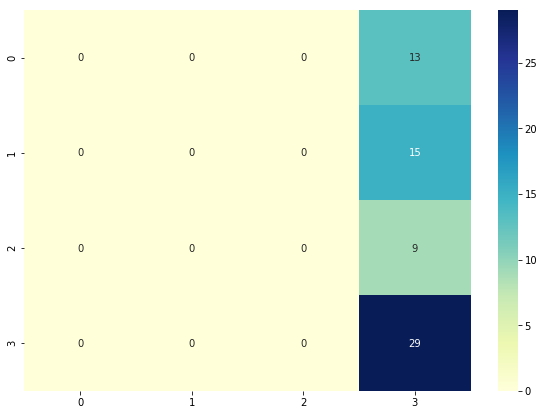

In [185]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, label_predicted)
import seaborn as sn
df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

In [186]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

# getting the data
print("----------------------------------- Implementing K Nearest Neighbours -------------------------------------------------------")
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)


# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)


print(" ----------------Training KNeighborsClassifier Model --------------")
classifier = KNeighborsClassifier(n_jobs=-1,n_neighbors= 5)
classifier.fit(X_train, y_train)

print("-------------------------Testing the Model------------------------")
label_predicted = classifier.predict(X_test)

accuracy = accuracy_score(y_test, label_predicted)

print("Test Accuracy ")
print(accuracy * 100)



----------------------------------- Implementing K Nearest Neighbours -------------------------------------------------------
Total Data 
(328, 36)
Total Data label 
(328,)
Dividing the data to train and test 
Dimensions of train data 
(262, 36)
Dimensions of training labels 
(262,)
Dimensions of test data 
(66, 36)
Dimensions of test labels 
(66,)
 ----------------Training KNeighborsClassifier Model --------------
-------------------------Testing the Model------------------------
Test Accuracy 
87.87878787878788


In [187]:
from sklearn import metrics
print (metrics.classification_report(y_test, label_predicted))

             precision    recall  f1-score   support

   Backhand       1.00      0.92      0.96        13
      Clear       0.71      1.00      0.83        15
      Serve       0.80      0.89      0.84         9
      Smash       1.00      0.79      0.88        29

avg / total       0.91      0.88      0.88        66



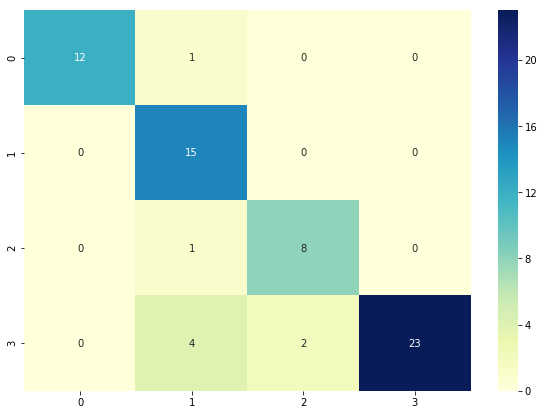

In [188]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, label_predicted)
import seaborn as sn
df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

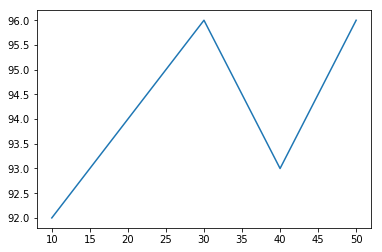

In [197]:
window_size= [10,20,30,40,50]
accuracy = [92,94,96,93,96]
plt.plot(window_size,accuracy)

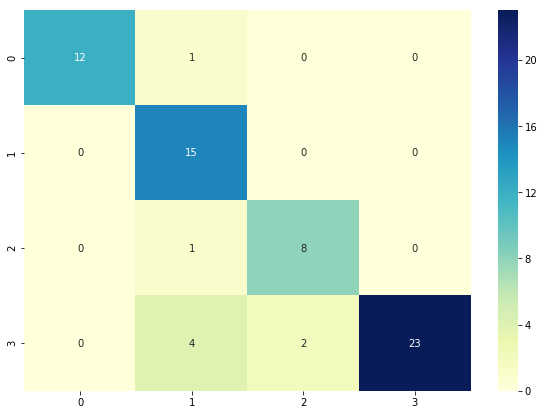

In [190]:
from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_test, label_predicted)
import seaborn as sn
df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

In [191]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# getting the data
print("----------------------------------- Implementing naive bayes Neighbours -------------------------------------------------------")
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)


# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)


print(" ----------------Training GaussianNB Model --------------")
classifier = GaussianNB()
classifier.fit(X_train, y_train)

print("-------------------------Testing the Model------------------------")
label_predicted = classifier.predict(X_test)

accuracy = accuracy_score(y_test, label_predicted)

print("Test Accuracy ")
print(accuracy * 100)





----------------------------------- Implementing naive bayes Neighbours -------------------------------------------------------
Total Data 
(328, 36)
Total Data label 
(328,)
Dividing the data to train and test 
Dimensions of train data 
(262, 36)
Dimensions of training labels 
(262,)
Dimensions of test data 
(66, 36)
Dimensions of test labels 
(66,)
 ----------------Training GaussianNB Model --------------
-------------------------Testing the Model------------------------
Test Accuracy 
96.96969696969697


In [192]:
from sklearn import metrics
print (metrics.classification_report(y_test, label_predicted))

             precision    recall  f1-score   support

   Backhand       0.87      1.00      0.93        13
      Clear       1.00      1.00      1.00        15
      Serve       1.00      1.00      1.00         9
      Smash       1.00      0.93      0.96        29

avg / total       0.97      0.97      0.97        66



In [193]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

# getting the data
print("----------------------------------- Implementing Logistic Regression Model -------------------------------------------------------")
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)


# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)


print(" ----------------Training GaussianNB Model --------------")
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# predict class labels for the test set
predicted = classifier.predict(X_test)
print (predicted)

# generate class probabilities
probs = classifier.predict_proba(X_test)
print (probs)

print("-------------------------10 fold cross validation------------------------")
label_predicted = classifier.predict(X_test)
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), total_data, total_label, scoring='accuracy', cv=10)
print (scores)
print (scores.mean() * 100)

print("-------------------------Testing the Model------------------------")
label_predicted = classifier.predict(X_test)

accuracy = accuracy_score(y_test, label_predicted)

print("Test Accuracy")
print(accuracy * 100)

----------------------------------- Implementing Logistic Regression Model -------------------------------------------------------
Total Data 
(328, 36)
Total Data label 
(328,)
Dividing the data to train and test 
Dimensions of train data 
(262, 36)
Dimensions of training labels 
(262,)
Dimensions of test data 
(66, 36)
Dimensions of test labels 
(66,)
 ----------------Training GaussianNB Model --------------
['Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash' 'Smash'
 'Smash' 'Smash' 'Smash']
[[0.14670588 0.20780429 0.27730069 0.36818914]
 [

In [194]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# getting the data
print("----------------------------------- Implementing naive bayes Neighbours -------------------------------------------------------")
total_data = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Data.csv')
total_label = pd.read_csv('C:/Users/dhruv/OneDrive/Desktop/698/Project/PreProccessed_Data_Window_Sizewise/W50/Train_Label.csv',header=None)
#total_label = total_label.astype('int')
total_data = total_data.fillna(0)


# normalizing the training data
total_data = normalize(total_data,axis=0)
total_label = total_label.values.ravel()

print("Total Data ")
print(total_data.shape)
print("Total Data label ")
print(total_label.shape)

print("Dividing the data to train and test ")
X_train, X_test, y_train, y_test = train_test_split(total_data, total_label, test_size=0.20, random_state=1)

print("Dimensions of train data ")
print(X_train.shape)
print("Dimensions of training labels ")
print(y_train.shape)
print("Dimensions of test data ")
print(X_test.shape)
print("Dimensions of test labels ")
print(y_test.shape)


print(" ----------------Training GaussianNB Model --------------")
classifier = DecisionTreeClassifier(min_samples_split=20, random_state=99)

classifier.fit(X_train, y_train)

print("-------------------------Testing the Model------------------------")
label_predicted = classifier.predict(X_test)

accuracy = accuracy_score(y_test, label_predicted)

print("Test Accuracy ")
print(accuracy * 100)


----------------------------------- Implementing naive bayes Neighbours -------------------------------------------------------
Total Data 
(328, 36)
Total Data label 
(328,)
Dividing the data to train and test 
Dimensions of train data 
(262, 36)
Dimensions of training labels 
(262,)
Dimensions of test data 
(66, 36)
Dimensions of test labels 
(66,)
 ----------------Training GaussianNB Model --------------
-------------------------Testing the Model------------------------
Test Accuracy 
86.36363636363636
